# ***imports***

In [1]:
!pip install numpy scipy
!pip install control


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import scipy.io
import numpy as np
from scipy.signal import step, lti
import control as cnt
import matplotlib.pyplot as plt

# ***1 - CARREGANDO DADOS***

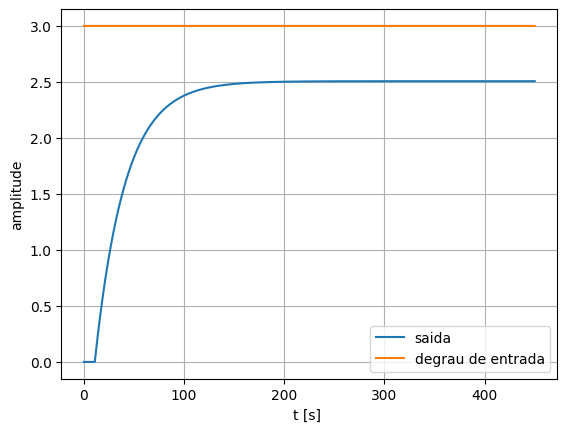

In [3]:
dataset = scipy.io.loadmat('datasets\Dataset_Grupo3.mat')
# print(dataset)

degrau_array = dataset.get('TARGET_DATA____ProjetoC213_Degrau')
saida_array = dataset.get('TARGET_DATA____ProjetoC213_Saida')
# print(degrau_array,saida_array)

tempo = degrau_array[:, 0]
saida = saida_array[:, 1]
degrau = degrau_array[:, 1]

amplitude_degrau = degrau[-1]
valor_final = saida[-1]

plt.plot(tempo,saida, label='saida')
plt.plot(tempo,degrau,label='degrau de entrada')
plt.xlabel('t [s] ')
plt.ylabel('amplitude')
plt.legend(loc="lower right")

plt.grid()
plt.savefig('imgs/dataset.png')
plt.show()


***GANHO ESTATICO***

***ATRASO E CONSTANTE DE TEMPO***


In [4]:
ganho_estatico = valor_final/amplitude_degrau
print(f'O ganho estatico do sistema e {ganho_estatico:.4f}.')

atraso = 0
constTemp = 0
for i in range(len(saida)):
  if (saida[i] != 0) and (atraso == 0):
    atraso = tempo[i-1]

  if saida[i] >= (0.6321*valor_final):
    constTemp = tempo[i] - atraso
    break

print(f'Valor de atraso: {atraso:.2f}.')
print(f'Constante de tempo: τ = {constTemp:.2f}S.')

O ganho estatico do sistema e 0.8355.
Valor de atraso: 10.90.
Constante de tempo: τ = 30.10S.


# ***2 - SMITH***

In [5]:
def Smith(degrau,tempo,saida):
  #Verificando se tempo e saida sao array do tipo numerico
  if not isinstance(tempo, np.ndarray) or not isinstance(saida, np.ndarray):
    raise TypeError('Deve ser array')

  if not np.isscalar(degrau):
    raise TypeError('Deve ser uma constante')

  saida = saida - saida[0]
  valor_final = saida[-1]
  k = valor_final/degrau

  t1 = 0
  t2 = 0
  for i in range(len(saida)):
    if saida[i] >= 0.283*valor_final and t1 == 0:
      t1 = tempo[i]
    if saida[i] >= 0.6321*valor_final:
      t2 = tempo[i]
      break

  tau = 1.5*(t2 - t1)
  theta = t2 - tau
  return k, tau, theta


In [6]:
k, tau, theta = Smith(amplitude_degrau,tempo,saida)
print("k = {}, τ = {}, Θ = {}.".format(k,tau,theta))

k = 0.8354996318314089, τ = 30.0, Θ = 11.0.


# ***3 - COMPARACAO***

In [7]:
sys = (k, [tau, 1])
tout, yout = step(sys, T=np.linspace(0, tempo[-1], len(tempo)))

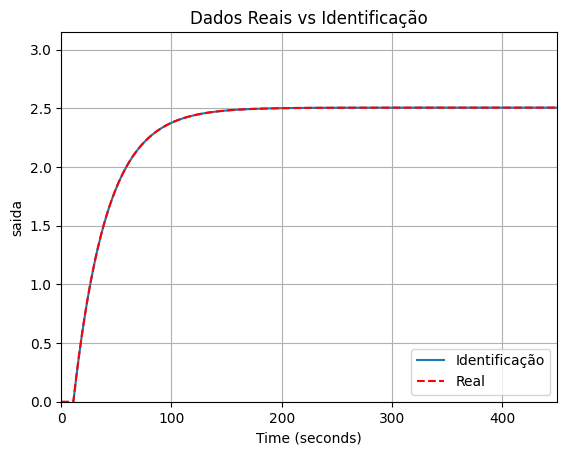

In [8]:
plt.figure()
plt.plot(tout + theta, yout * amplitude_degrau, label='Identificação')
plt.plot(tempo, saida, 'r--', label='Real')

# Definindo label e limites para os eixos:
plt.xlabel('Time (seconds)')
plt.xlim([0, len(tempo) * 0.1])

plt.ylabel('saida')
plt.ylim([0, max(max(degrau), max(yout * amplitude_degrau)) * 1.05])

# Definindo o título e a posição da legenda do gráfico:
plt.title('Dados Reais vs Identificação')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('imgs/comparacao.png')
plt.show()


# ***4 - RESPOSTA DO SISTEMA***

### ***MALHA ABERTA***

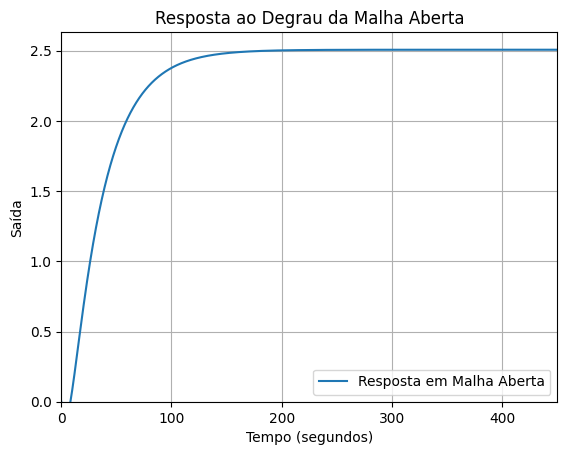

In [9]:
g_aberto = cnt.tf([k], [tau, 1])
# adicionando atraso
num_delay, den_delay = cnt.pade(theta, 1)
g_delay = cnt.series(cnt.tf(num_delay, den_delay),g_aberto)
t_a, y_a = cnt.step_response(g_delay, tempo)

plt.plot(t_a, y_a * amplitude_degrau, label='Resposta em Malha Aberta')
# Definindo label e limites para os eixos
plt.xlabel('Tempo (segundos)')
plt.xlim([0, len(tempo) * 0.1])
plt.ylabel('Saída')
plt.ylim([0, max(yout * amplitude_degrau) * 1.05])

plt.title('Resposta ao Degrau da Malha Aberta')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('imgs/malha_aberta.png')
plt.show()

### ***MALHA FECHADA***

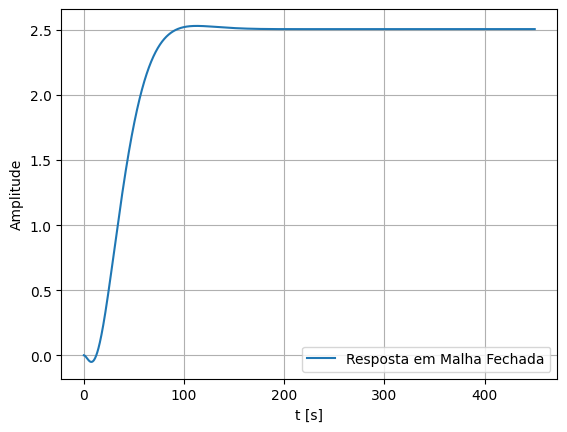

In [10]:
g_fechado = cnt.tf([k], [tau * theta, tau , 1])

# Adicionando atraso
num_delay, den_delay = cnt.pade(theta, 1)
g_fechado_delay = cnt.series(cnt.tf(num_delay, den_delay), g_fechado)

# Resposta ao degrau em malha fechada
t_f, y_f = cnt.step_response(g_fechado_delay, tempo)

# Plot da resposta ao degrau em malha fechada
plt.plot(t_f, y_f * amplitude_degrau, label='Resposta em Malha Fechada')
plt.xlabel('t [s]')
plt.ylabel('Amplitude')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('imgs/mf_resposta.png')
plt.show()

# ***5 - PID***

***IMC***        
 λ/θ > 0.8

 θ = 11

 λ > 8.8

In [11]:
lamb = 50
kp_imc = (2 * tau + theta) / (k * (2 * lamb + theta))
ti_imc = tau + (theta / 2)
td_imc = (tau * theta) / (2 * tau + theta)
print("Kp_imc = {:.4f}, Ti_imc = {:.4f}, Td_imc = {:.4f}.".format(kp_imc, ti_imc, td_imc))

Kp_imc = 0.7656, Ti_imc = 35.5000, Td_imc = 4.6479.


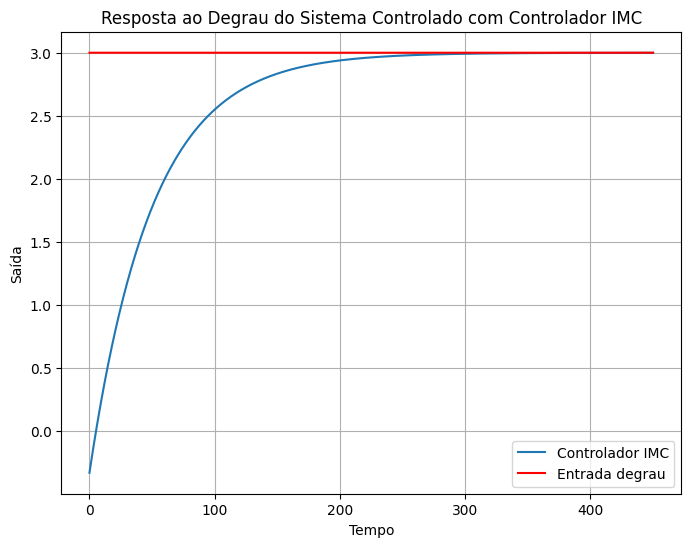

In [12]:
num_pid_imc = [kp_imc * td_imc, kp_imc, kp_imc / ti_imc]
den_pid_imc = [1, 0]

PID_imc = cnt.tf(num_pid_imc, den_pid_imc)

# Adicionando atraso
num_delay, den_delay = cnt.pade(theta, 1)
pid_imc_delay = cnt.series(cnt.tf(num_delay, den_delay), PID_imc)

sys_atraso = cnt.tf(k, [tau, 1])
imc = cnt.series(sys_atraso, pid_imc_delay)

sys_ctrl_imc = cnt.feedback(imc, 1)
temp, resp_imc = cnt.step_response(sys_ctrl_imc * amplitude_degrau, tempo)

plt.figure(figsize=(8, 6))
plt.plot(temp, resp_imc, label='Controlador IMC')
plt.plot(tempo, degrau, 'r', label='Entrada degrau')

plt.title('Resposta ao Degrau do Sistema Controlado com Controlador IMC')
plt.xlabel('Tempo')
plt.ylabel('Saída')
plt.grid()
plt.legend()
plt.savefig('imgs/IMC.png')
plt.show()

In [13]:
imc_info = cnt.step_info(sys_ctrl_imc)
rise_time_imc = imc_info['RiseTime']
settling_time_imc = imc_info['SettlingTime']
overshoot_imc = imc_info['Overshoot']

print(f'RISE TIME: {rise_time_imc:.4f}')
print(f'SETTLING TIEM: {settling_time_imc:.4f}')
print(f'OVERSHOOT: {overshoot_imc:.4f}')

RISE TIME: 108.1517
SETTLING TIEM: 202.3484
OVERSHOOT: 0.0000


***ITAE***
```
a = 0.965       b = -0.85

c = 0.796       d = -0.147

e = 0.308       f = 0.929
```

In [14]:
a, b, c, d, e, f = 0.965, -0.85, 0.796, -0.147, 0.308, 0.929

kp_itae = (a / k) * ((theta / tau) ** b)
ti_itae = tau / (c + (d * (theta / tau)))
td_itae = tau * e * ((theta / tau) ** f)
print("Kp = {:.4f}, Ti = {:.4f}, Td = {:.4f}.".format(kp_itae, ti_itae, td_itae))

Kp = 2.7099, Ti = 40.4258, Td = 3.6381.


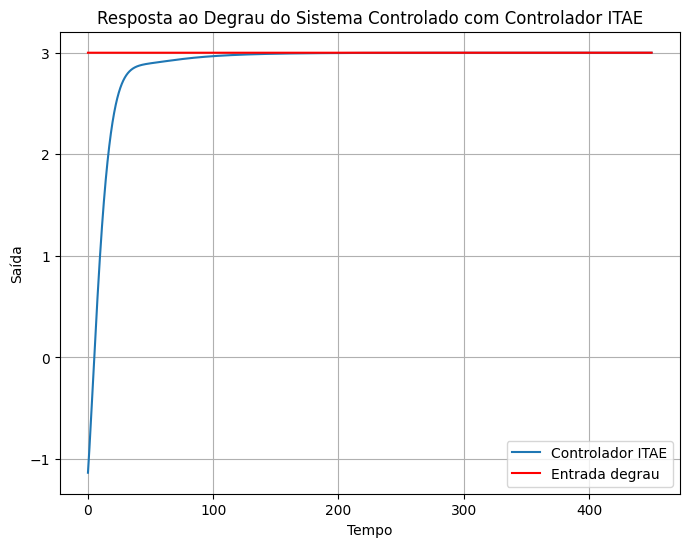

In [15]:
num_pid_itae = [kp_itae * td_itae, kp_itae, kp_itae / ti_itae]
den_pid_itae = [1, 0]

PID_itae = cnt.tf(num_pid_itae, den_pid_itae)

# Adicionando atraso
num_delay, den_delay = cnt.pade(theta, 1)
pid_itae_delay = cnt.series(cnt.tf(num_delay, den_delay), PID_itae)

sys_atraso = cnt.tf(k, [tau, 1])
itae = cnt.series(pid_itae_delay, sys_atraso)

sys_ctrl_itae = cnt.feedback(itae, 1)
temp, resp_itae = cnt.step_response(sys_ctrl_itae * amplitude_degrau, tempo)

plt.figure(figsize=(8, 6))
plt.plot(temp, resp_itae, label='Controlador ITAE')
plt.plot(tempo, degrau, 'r', label='Entrada degrau')

plt.title('Resposta ao Degrau do Sistema Controlado com Controlador ITAE')
plt.xlabel('Tempo')
plt.ylabel('Saída')
plt.grid()
plt.legend()
plt.savefig('imgs/ITAE.png')
plt.show()

In [16]:
itae_info = cnt.step_info(sys_ctrl_itae)
# print(imc_info)
rise_time_itae = itae_info['RiseTime']
settling_time_itae = itae_info['SettlingTime']
overshoot_itae = itae_info['Overshoot']

print(f'RISE TIME: {rise_time_itae:.4f}')
print(f'SETTLING TIEM: {settling_time_itae:.4f}')
print(f'OVERSHOOT: {overshoot_itae:.4f}')

RISE TIME: 21.0078
SETTLING TIEM: 77.0286
OVERSHOOT: 0.0000
